# C S 329E HW 11

# Association Analysis - Frequent Itemsets and Rule Generation

## Your name here (and your partner's name if you are working in a pair)

Association analysis uses machine learning algorithms to extract hidden relationships from large datasets. In this assignment we'll be using one of the most commonly used algorithms for association rule mining - the Apriori algorithm.

`scikit-learn` does not provide any functionality for association rule mining so for this assignment you will be using the `MLxtend` library. The documentation for this library is available [here](http://rasbt.github.io/mlxtend/).

You will need to install the `MLxtend` library. There are several ways of doing this; see the setup guide  [here](http://rasbt.github.io/mlxtend/installation/).

## Bread Basket Data

The dataset belongs to "The Bread Basket" a bakery located in Edinburgh. The dataset has 21293 entires, over 6000 transactions and 4 columns:

  - Date: Categorical variable that tells us the date of the transactions (YYYY-MM-DD format).
  - Time: Categorical variable that tells us the time of the transactions (HH:MM:SS format). 
  - Transaction: Quantitative variable that allows us to differentiate the transactions. The rows that share the same value in this field belong to the same transaction, that's why the data set has less transactions than observations.
  - Item: Categorical variable with the products.

You'll need to clean up the input data and convert it to a transaction list with itemsets, and find itemsets that occur more than the `min_sup` threshold. Based on these frequent itemsets you'll find association rules that have confidence above the `min_conf` threshold.

In [1]:
# Do not modify import block, all necessary imports are included

# Our regular libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# This is for our association analysis 
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

## Q1 - Data Analysis
The data has been delivered to us in a format that doesn't match the transaction format that we used in the lecture to create frequent itemsets, but instead in a one item per line format that contains a transaction ID.  Let's visualize what kind of data we have.

Load the `BreadBasket.csv` file into a dataframe and:

  1. Plot the most frequent 20 items in a a histogram.  You may use panda's `value_counts` with the [matplotlib](https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/categorical_variables.html) documentation on how to create a histogram with categorical data. Make sure your axis is readable and labeled.  I used a figsize of (15,5).
  2. Calculate how many unique items are in the dataset
  3. Calculate how many transactions there are in the dataset 
  
As you may notice there is an item with the name `NONE` ... remove all of those before you answer the above questions.

In [2]:
df_old = pd.read_csv('BreadBasket.csv')
df = df_old [df_old['Item'] != 'NONE'] #remove NONE values
df

,Date,Time,Transaction,Item
0,2016-10-30,09:58:11,1,Bread
1,2016-10-30,10:05:34,2,Scandinavian
2,2016-10-30,10:05:34,2,Scandinavian
3,2016-10-30,10:07:57,3,Hot chocolate
4,2016-10-30,10:07:57,3,Jam
...,...,...,...,...
21288,2017-04-09,14:32:58,9682,Coffee
21289,2017-04-09,14:32:58,9682,Tea
21290,2017-04-09,14:57:06,9683,Coffee
21291,2017-04-09,14:57:06,9683,Pastry


Text(0.5, 1.0, '20 most frequent items')

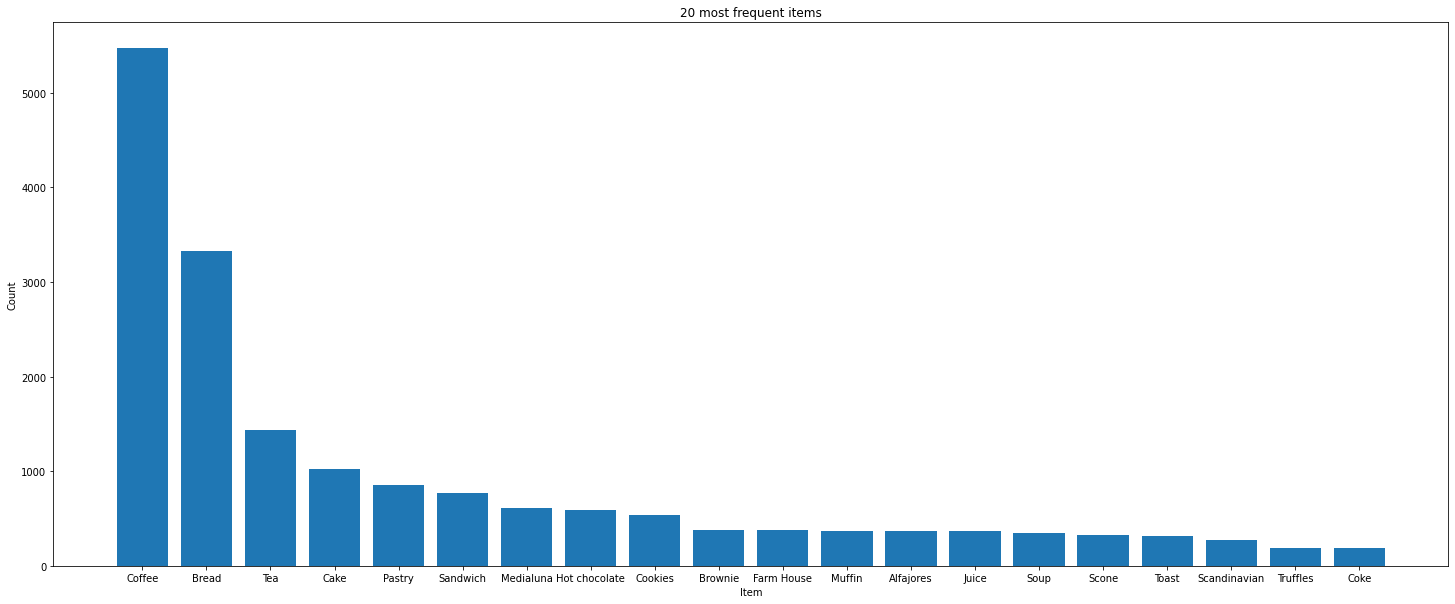

In [3]:
#get the value counts
counts = df['Item'].value_counts()
most = counts[0:20]

#create histogram
names = most.keys()
values = most.values
plt.figure(figsize=(25, 10))
plt.bar(names, values)
plt.xlabel('Item')
plt.ylabel('Count')
plt.title('20 most frequent items')

In [4]:
#Calculate unique items in the dataset
df['Item'].nunique()

94

In [5]:
#Calculate how many transactions there are in the dataset
df['Transaction'].nunique()

9465

## Q2 - Data Prep: Convert to One Hot Encoded Transactions
Convert the data to a transaction array.  The transaction array is a list of lists, for example:

```
dataset = [['Milk', 'Onion', 'Nutmeg', 'Kidney Beans', 'Eggs', 'Yogurt'],
           ['Dill', 'Onion', 'Nutmeg', 'Kidney Beans', 'Eggs', 'Yogurt'],
           ['Milk', 'Apple', 'Kidney Beans', 'Eggs'],
           ['Milk', 'Unicorn', 'Corn', 'Kidney Beans', 'Yogurt'],
           ['Corn', 'Onion', 'Onion', 'Kidney Beans', 'Ice cream', 'Eggs']]
```

Pandas has a special function called `groupby` which we can use to collate all of the items with the same transaction ID into a list.  Here is a nice [tutorial](https://realpython.com/pandas-groupby/). You can get the list of lists of transactions by grouping the data by "Transaction" column, referencing the "Item" column, then applying a list.  This gives you a series with the transaction ID equal to the index, but the [TransactionEncoder](http://rasbt.github.io/mlxtend/user_guide/preprocessing/TransactionEncoder/) to prep the data for our library just wants the values of that series. 

There are other methods you may use to create the transaction array using the `BreadBasked.csv` data with the `NONE` values filtered out, but they might require a little more code than the methodology suggested above.

Use the `mlxtend` TransactionEncoder library to encode the transaction array in a one hot encoding. Create the one hot encoding using the TransactionEncoder, and check it was done properly by looking at the first 4 transactions using the `inverse_transform`. Finish off the data prep for the frequent itemset generation by converting the transactions back to a dataframe using the [documentation](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/) as a reference. 

In [6]:
group = df.groupby("Transaction")["Item"]
group_arr = []
for transaction, item in group:
    item = list(item)
    group_arr.append(item)

In [7]:
te = TransactionEncoder()
te_ary = te.fit(group_arr).transform(group_arr)
te_ary = te_ary.astype("int")

In [8]:
first4 = te_ary[:4]
te.inverse_transform(first4)

[['Bread'], ['Scandinavian'], ['Cookies', 'Hot chocolate', 'Jam'], ['Muffin']]

In [9]:
df_tran = pd.DataFrame(te_ary, columns=te.columns_)
df_tran

,Adjustment,Afternoon with the baker,Alfajores,Argentina Night,Art Tray,Bacon,Baguette,Bakewell,Bare Popcorn,Basket,...,The BART,The Nomad,Tiffin,Toast,Truffles,Tshirt,Valentine's card,Vegan Feast,Vegan mincepie,Victorian Sponge
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9460,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9461,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
9462,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9463,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Q3 - Create Frequent Itemsets 
Using the [apriori](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/) method, create a frequent itemset that we can use to create rules with.  Unlike in the lecture notes, this implementation doesn't use an integer _minsup_ , it refers to support of the percent of the transactions that it has to contain to be frequent.  Since we have 9465 transactions, if we want _minsup_ to be 100, then the library expects a `min_support` fraction of $\frac{100}{9465}$. Find all the frequent item sets with _minsup_ set to 20. Show the last 15 frequent item sets displaying the item names (not the item column indices). 

In [10]:
freq_itm = apriori(df_tran, min_support= 20/9465, use_colnames=True)

In [23]:
freq_itm.tail(15)

,support,itemsets
229,0.003909,"(Coffee, Cookies, Tea)"
230,0.003064,"(Coffee, Medialuna, Hot chocolate)"
231,0.003803,"(Pastry, Coffee, Hot chocolate)"
232,0.002536,"(Coffee, Hot chocolate, Sandwich)"
233,0.002747,"(Coffee, Juice, Sandwich)"
234,0.004860,"(Pastry, Coffee, Medialuna)"
235,0.003698,"(Coffee, Medialuna, Tea)"
236,0.002853,"(Muffin, Coffee, Tea)"
237,0.004649,"(Pastry, Coffee, Tea)"
238,0.003592,"(Coffee, Soup, Sandwich)"


## Q4 - Generate Strong Rules
Use the [association_rules](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/) to calculate rules with a confidence level of 0.5 for the frequent itemsets you generated in Q3.

You should notice something in common with all of the rules.  Are these rules helpful for our bakery? 

In [12]:
rules = association_rules(freq_itm, metric="confidence", min_threshold=0.5)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Alfajores),(Coffee),0.036344,0.478394,0.019651,0.540698,1.130235,0.002264,1.135648
1,(Art Tray),(Coffee),0.004015,0.478394,0.002747,0.684211,1.430224,0.000826,1.651752
2,(Bakewell),(Coffee),0.005071,0.478394,0.003064,0.604167,1.262906,0.000638,1.317741
3,(Cake),(Coffee),0.103856,0.478394,0.054728,0.526958,1.101515,0.005044,1.102664
4,(Cookies),(Coffee),0.054411,0.478394,0.028209,0.518447,1.083723,0.002179,1.083174
5,(Extra Salami or Feta),(Coffee),0.004015,0.478394,0.003275,0.815789,1.705267,0.001355,2.831575
6,(Frittata),(Coffee),0.008558,0.478394,0.004543,0.530864,1.109680,0.000449,1.111844
7,(Hearty & Seasonal),(Coffee),0.010565,0.478394,0.005705,0.540000,1.128777,0.000651,1.133926
8,(Hot chocolate),(Coffee),0.058320,0.478394,0.029583,0.507246,1.060311,0.001683,1.058553
9,(Jammie Dodgers),(Coffee),0.013207,0.478394,0.006656,0.504000,1.053525,0.000338,1.051625


Coffee is the consequent for all of the items, meaning that people who buy these antecedents are likely to buy coffee. This is not very helpful to the bakery because they probably already know that people buy coffee with most items

### Q5 - Generate Strong Rules (pt 2)
While reading the documentation for creating [association rules](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/) you notice that there are many other metrics to choose from.  Try creating rules with the following:
   - lift > 3
   - leverage > 0.004
   - conviction > 1.2

In [13]:
rules2 = association_rules(freq_itm, metric="lift", min_threshold=3)
rules2

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Coke),(Sandwich),0.019440,0.071844,0.005177,0.266304,3.706722,0.003780,1.265043
1,(Sandwich),(Coke),0.071844,0.019440,0.005177,0.072059,3.706722,0.003780,1.056705
2,(Fudge),(Jam),0.015003,0.015003,0.002536,0.169014,11.265622,0.002311,1.185336
3,(Jam),(Fudge),0.015003,0.015003,0.002536,0.169014,11.265622,0.002311,1.185336
4,(Jammie Dodgers),(Juice),0.013207,0.038563,0.002113,0.160000,4.149041,0.001604,1.144568
5,(Juice),(Jammie Dodgers),0.038563,0.013207,0.002113,0.054795,4.149041,0.001604,1.043999
6,(Spanish Brunch),(Juice),0.018172,0.038563,0.002747,0.151163,3.919879,0.002046,1.132652
7,(Juice),(Spanish Brunch),0.038563,0.018172,0.002747,0.071233,3.919879,0.002046,1.057130
8,(Mineral water),(Sandwich),0.014157,0.071844,0.003275,0.231343,3.220094,0.002258,1.207504
9,(Sandwich),(Mineral water),0.071844,0.014157,0.003275,0.045588,3.220094,0.002258,1.032932


In [14]:
rules3 = association_rules(freq_itm, metric="leverage", min_threshold=0.004)
rules3

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Coffee),(Cake),0.478394,0.103856,0.054728,0.114399,1.101515,0.005044,1.011905
1,(Cake),(Coffee),0.103856,0.478394,0.054728,0.526958,1.101515,0.005044,1.102664
2,(Cake),(Hot chocolate),0.103856,0.058320,0.011410,0.109868,1.883874,0.005354,1.057910
3,(Hot chocolate),(Cake),0.058320,0.103856,0.011410,0.195652,1.883874,0.005354,1.114125
4,(Tea),(Cake),0.142631,0.103856,0.023772,0.166667,1.604781,0.008959,1.075372
5,(Cake),(Tea),0.103856,0.142631,0.023772,0.228891,1.604781,0.008959,1.111865
6,(Coffee),(Medialuna),0.478394,0.061807,0.035182,0.073542,1.189878,0.005614,1.012667
7,(Medialuna),(Coffee),0.061807,0.478394,0.035182,0.569231,1.189878,0.005614,1.210871
8,(Pastry),(Coffee),0.086107,0.478394,0.047544,0.552147,1.154168,0.006351,1.164682
9,(Coffee),(Pastry),0.478394,0.086107,0.047544,0.099382,1.154168,0.006351,1.014740


In [15]:
rules4 = association_rules(freq_itm, metric="conviction", min_threshold=1.2)
rules4

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Art Tray),(Coffee),0.004015,0.478394,0.002747,0.684211,1.430224,0.000826,1.651752
1,(Bakewell),(Coffee),0.005071,0.478394,0.003064,0.604167,1.262906,0.000638,1.317741
2,(Extra Salami or Feta),(Coffee),0.004015,0.478394,0.003275,0.815789,1.705267,0.001355,2.831575
3,(Keeping It Local),(Coffee),0.006656,0.478394,0.005388,0.809524,1.692169,0.002204,2.738431
4,(Medialuna),(Coffee),0.061807,0.478394,0.035182,0.569231,1.189878,0.005614,1.210871
5,(Salad),(Coffee),0.010460,0.478394,0.006550,0.626263,1.309094,0.001547,1.395648
6,(Spanish Brunch),(Coffee),0.018172,0.478394,0.010882,0.598837,1.251766,0.002189,1.300235
7,(Tartine),(Coffee),0.004860,0.478394,0.003064,0.630435,1.317815,0.000739,1.411404
8,(Toast),(Coffee),0.033597,0.478394,0.023666,0.704403,1.472431,0.007593,1.764582
9,(Vegan mincepie),(Coffee),0.005494,0.478394,0.003170,0.576923,1.205958,0.000541,1.232887


## Q6 - Find the Maximal Itemsets
Using the frequent itemsets and support counts in Q3, find and display all the maximal frequent itemsets along with their support fraction. Also print a count of how many maximal frequent itemsets you have found. (MLxtend does not provide a function to do this - you will need to write it yourself.)

In [50]:
idx_arr = np.zeros(len(freq_itm))
for i,row in freq_itm.iterrows():
    vals = list(freq_itm['itemsets'].values[i])
    for j, r in freq_itm.iterrows():
        oth_set = list(freq_itm['itemsets'].values[j])
        if i != j and len(oth_set) > len(vals):
            is_super = True
            for x in vals:
                if x not in oth_set:
                    is_super = False
            if is_super:
                idx_arr[i] = 1
                break     
maximal_itemsets = freq_itm [idx_arr == 0]
print(maximal_itemsets.to_string())
print('There were {} maximal itemsets found'.format(len(maximal_itemsets)))

      support                            itemsets
0    0.004543          (Afternoon with the baker)
12   0.002958                              (Eggs)
15   0.005705                          (Focaccia)
18   0.002958                           (Granola)
42   0.002219                            (Tshirt)
45   0.002853                (Alfajores, Brownie)
48   0.002430                (Alfajores, Cookies)
49   0.003592          (Alfajores, Hot chocolate)
50   0.003064                  (Alfajores, Juice)
51   0.003170              (Alfajores, Medialuna)
52   0.003275                 (Pastry, Alfajores)
53   0.002641               (Alfajores, Sandwich)
55   0.002747                  (Art Tray, Coffee)
56   0.002747                   (Baguette, Bread)
57   0.002958                  (Baguette, Coffee)
58   0.003064                  (Coffee, Bakewell)
61   0.002747               (Bread, Chicken Stew)
64   0.004966                 (Bread, Farm House)
65   0.002641                   (Bread, Frittata)


## Q7 - Create Actionable Buisness Insight
Pretend you are a consultant contracted to work for this bakery and come up with a promotion to increase sales. You have performed the above analysis, now how would you suggest the bakery use this data?

Be creative.  It could be in training employees, programming the cash register, advertising specials, etc.. Describe your approach and why you think the data supports it.  

**Based on the results from Q4, we would propose slightly increasing the price of coffee and having a sale on food items because people are very likely to buy coffee once we get them in the door for food.**

**The next proposal would be to create a family bundle comprised of a coffee, tea, and two food items. This is because we noticed many of the maximal frequent item sets were comprised of coffee, tea, and one other food item. This family bundle will encourage the sale of two food items instead of one.**